#Summary Results


* Used Text Length as a feature with TFIDF
*   Combined Mispelled word count as another feature for attempt to improve performance scores
* Hyperparameter tuning: Improved accuracy score overall, and recall score for spam detection

Scores:


*   Accuracy: 0.95
*   F1 scores: 0.97
* Cross Validation: 0.94
*AUC score: 0.98







#Import Necessary Libraries

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV # For hyperparameters tuning
from sklearn.feature_extraction.text import TfidfVectorizer # Vectorizor for number representations of words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
import scipy.sparse as sp
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
import nltk

# # Download necessary NLTK data for Mispelling word count feature
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Load the Preprocesssed Final Version of Dataset

1.   Removed unnecessary columns
2.   Replaced empty 'Subject' with space and remove rows with missing 'Body'
3. Normalize text: convert to lowercase, remove special characters, and trim whitespaces




In [46]:
data = pd.read_csv('/content/masterDataset.csv')
X = data['Body']
y = data['label']

# Split the data into 70% training, 15% validation, and %15 test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


#TF-IDF (Term Frequency-Inverse Document Frequency)
A strong feature extraction technique focusing on the importance of a word in a document relative to a collection of documents. Improves the model  

In [47]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train.values.astype('U'))
X_val_tfidf = vectorizer.transform(X_val.values.astype('U'))
X_test_tfidf = vectorizer.transform(X_test.values.astype('U'))

#Feature Addition #1: Text Length

In [48]:
# Define the function to compute text length
def compute_text_length(text):
    if isinstance(text, str):
        return len(text)
    else:
        return 0

# Compute text length
X_train_length = np.array(X_train.apply(compute_text_length))
X_val_length = np.array(X_val.apply(compute_text_length))
X_test_length = np.array(X_test.apply(compute_text_length))


# Combine TF-IDF features and text length
X_train_combined = sp.hstack((X_train_tfidf,X_train_length[:, None]))
X_val_combined = sp.hstack((X_val_tfidf,X_val_length[:, None]))
X_test_combined = sp.hstack((X_test_tfidf,X_test_length[:, None]))

#Random Forest Classifier

In [49]:
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier.fit(X_train_combined, y_train)

RandomForestClassifier(random_state=42)

#Evaluating the Model with TFIDF and Text Length Features

In [50]:
# Evaluate the final model on the test set
y_test_pred = rf_classifier.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
# Generate classification report
class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.9585

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1804
           1       0.99      0.89      0.93       896

    accuracy                           0.96      2700
   macro avg       0.97      0.94      0.95      2700
weighted avg       0.96      0.96      0.96      2700


Confusion Matrix:
[[1794   10]
 [ 102  794]]



Confusion Matrix:
[[1794   10]
 [ 102  794]]


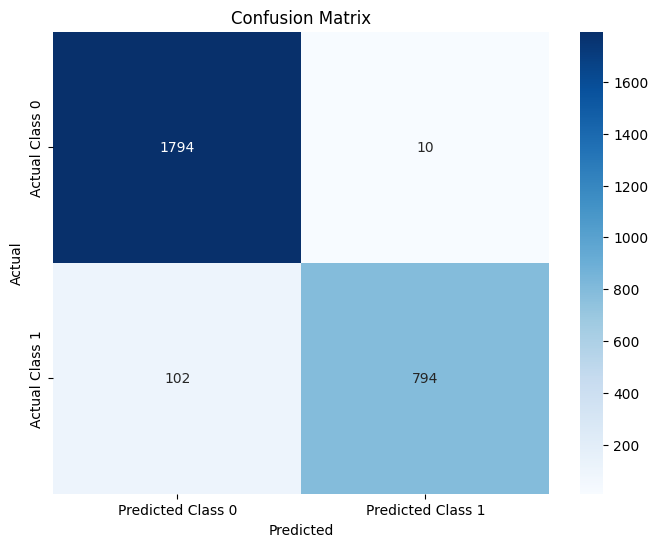

In [51]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['Actual Class 0', 'Actual Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Adding Feature #2: Mispelled Words Count

Counting the number of misspelled words using a predefined dictionary,indicates phishing attempts or unprofessional emails, as these often contain higher rates of misspellings

An atempt to improve the performance scores the precision and recall




In [52]:
spell = SpellChecker()

def count_misspelled_words(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        misspelled = spell.unknown(tokens)
        return len(misspelled)
    else:
        return 0

# Compute text length
X_train_length = np.array(X_train.apply(compute_text_length))
X_val_length = np.array(X_val.apply(compute_text_length))
X_test_length = np.array(X_test.apply(compute_text_length))


X_train_misspelled = np.array(X_train.apply(count_misspelled_words))
X_val_misspelled = np.array(X_val.apply(count_misspelled_words))
X_test_misspelled = np.array(X_test.apply(count_misspelled_words))

# Combine TF-IDF features, misspelled word counts, and text length
X_train_combined = sp.hstack((X_train_tfidf, X_train_misspelled[:, None], X_train_length[:, None]))
X_val_combined = sp.hstack((X_val_tfidf, X_val_misspelled[:, None], X_val_length[:, None]))
X_test_combined = sp.hstack((X_test_tfidf, X_test_misspelled[:, None], X_test_length[:, None]))

In [53]:
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier.fit(X_train_combined, y_train)

RandomForestClassifier(random_state=42)

In [54]:
# Evaluate the final model on the test set
y_test_pred = rf_classifier.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
# Generate classification report
class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.9544

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1804
           1       0.99      0.87      0.93       896

    accuracy                           0.95      2700
   macro avg       0.96      0.93      0.95      2700
weighted avg       0.96      0.95      0.95      2700


Confusion Matrix:
[[1794   10]
 [ 113  783]]



Confusion Matrix:
[[1794   10]
 [ 113  783]]


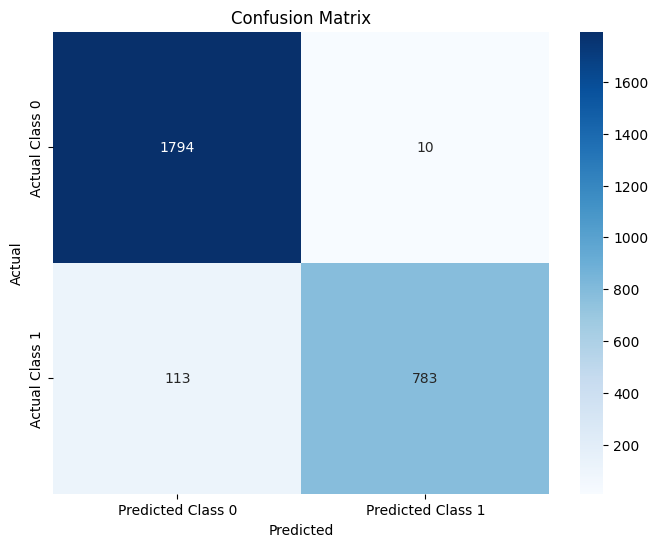

In [55]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['Actual Class 0', 'Actual Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#HyperTuning Parameters using RandomizedSearchCV and Cross Validation
Perform grid search with 5-fold cross-validation to find the best hyperparameters of the model

Note: GridSearchCV was atempted, but it was very time consuming and the execution kept on crashing. As an alternative, RandomizedSearchCV was utilized and limited to only 50 iterations of search of the best parameter combinations

In [56]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X_train_combined, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.4f}')



Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 120}
Best Cross-Validation Score: 0.9447


With the Best parameters used, validation data was used to predict and the model's accuracy slighlt improved to 96% and the recall value for spam detection improved from %86 to %88

In [57]:
# Train the Random Forest model with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train_combined, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=120, random_state=42)

Validation Accuracy: 0.9493
Test Accuracy: 0.9548

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1804
           1       0.99      0.88      0.93       896

    accuracy                           0.95      2700
   macro avg       0.96      0.94      0.95      2700
weighted avg       0.96      0.95      0.95      2700


Confusion Matrix:
[[1793   11]
 [ 111  785]]


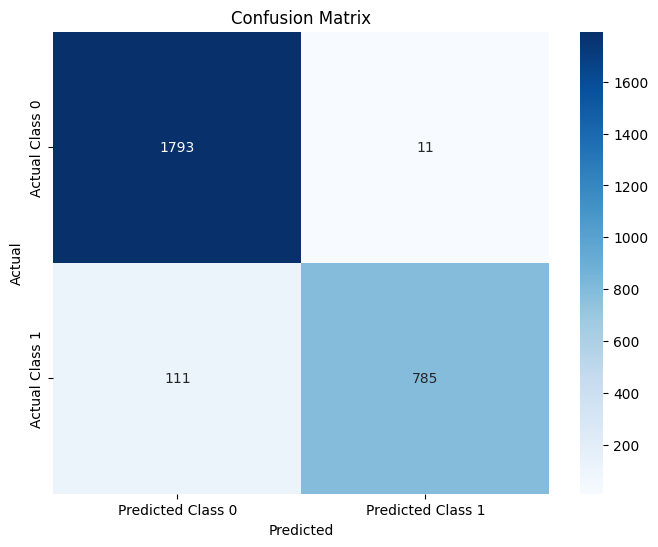

In [60]:
# Predict on the validation set
y_val_pred = best_rf_classifier.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Predict on the test set
y_test_pred = best_rf_classifier.predict(X_test_combined)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report
class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

#Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['Actual Class 0', 'Actual Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#ROC and AUC

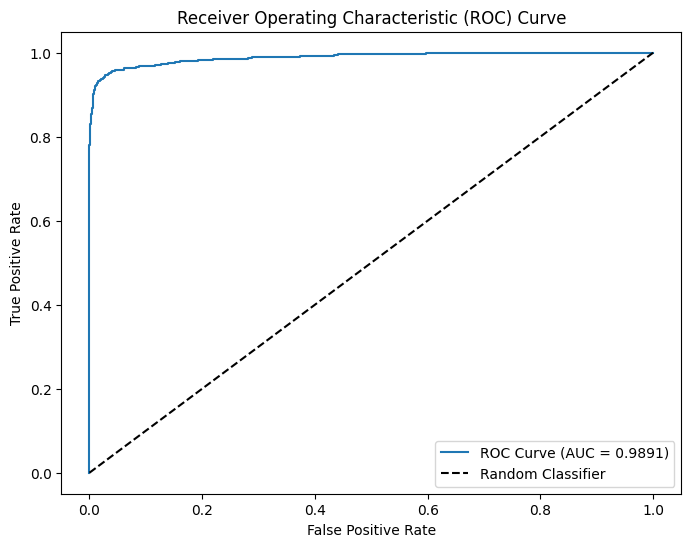

AUC Score: 0.9891


In [61]:
# Calculate ROC Curve and AUC Score
y_test_prob = best_rf_classifier.predict_proba(X_test_combined)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
auc_score = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f'AUC Score: {auc_score:.4f}')